# LOW-RANK PARAREAL: LYAPUNOV EQUATION

## IMPORTATIONS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

from src import problem_set
from src import parareal
from src import classical_solvers
from src import DLRA_solvers
from src import plotting

## SETUP THE PROBLEM

In [2]:
#%% CREATE PROBLEM
t_span = (0.01, 2.01)
size = 50
PB = problem_set.make_stiff_problem(t_span, size)

print(PB)

Lyapunov problem with following properties 
Shape: (50, 50) 
Initial rank: 50 
Time interval: (0.01, 2.01) 
Current ODE type: F 
Closed form solution available: True


## COMPUTE THE REFERENCE SOLUTION

In [3]:
nb_t_steps = 20
full_iv = PB.Y0.full()
ref_sol = classical_solvers.solve(PB, t_span, full_iv, nb_t_steps=nb_t_steps, monitoring=True)

Solving with optimal: 100%|██████████| 20/20 [00:00<00:00, 32.03it/s]


## VISUALIZATION OF THE SOLUTION

### ANIMATION

In [4]:
x = np.linspace(-1, 1, size)
anim_sol = plotting.animation_3D(x, x, ref_sol.Ys, title='figures/lyapunov/animation_3D_solution.gif', do_save=True)
HTML(anim_sol.to_jshtml())

MovieWriter ffmpeg unavailable; using Pillow instead.


### PLOTS

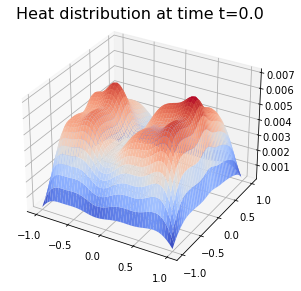

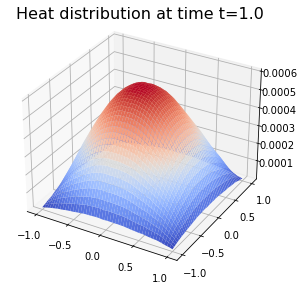

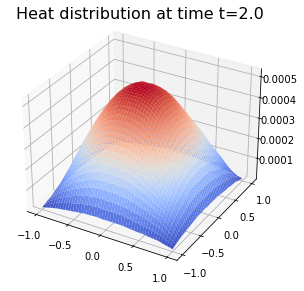

In [5]:
i_times = (0, 10, 20)
index = np.arange(1, 51)

for i in i_times:
    t = ref_sol.ts[i]
    X, Y = np.meshgrid(x, x)
    fig = plotting.plot_3D(X, Y, ref_sol.Ys[i], title=f'Heat distribution at time t={round(t - t_span[0], 2)}')
    fig.savefig(f'figures/lyapunov/3D_solution_t_{i}.pdf')

## SINGULAR VALUES

### ANIMATION

In [6]:
ts = ref_sol.ts
anim_sing_vals = plotting.singular_values(ts, ref_sol.Ys, title='figures/lyapunov/animation_sing_vals.gif', do_save=True)
HTML(anim_sing_vals.to_jshtml())

MovieWriter ffmpeg unavailable; using Pillow instead.


### PLOTS

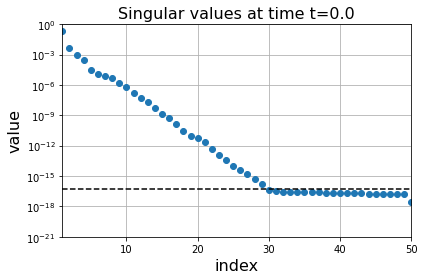

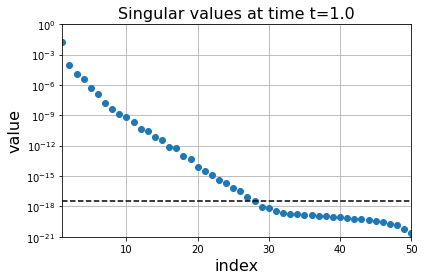

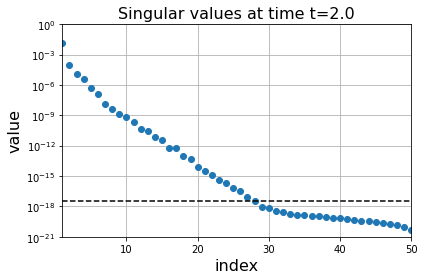

In [7]:
i_times = (0, 10, 20)
index = np.arange(1, 51)

for i in i_times:
    t = ref_sol.ts[i]
    sing_vals = np.linalg.svd(ref_sol.Ys[i], compute_uv=False)

    fig = plt.figure(clear=True)
    plt.semilogy(index, sing_vals, 'o')
    plt.semilogy(index, sing_vals[0] * np.finfo(float).eps * np.ones(len(sing_vals)), 'k--')
    plt.title(f'Singular values at time t={round(t-0.01, 2)}', fontsize=16)
    plt.xlim((1,50))
    plt.xlabel('index', fontsize=16)
    plt.ylim((1e-21, 1e0))
    plt.ylabel('value', fontsize=16)
    plt.tight_layout()
    plt.grid()
    plt.show()
    fig.savefig(f'figures/lyapunov/sing_vals_t_{i}.pdf')


## LOW RANK PARAREAL : ANIMATION

### COMPUTATION

In [8]:
coarse_rank = 2
fine_rank = 20
ts, Unk, coarse_sol, fine_sol = parareal.Low_Rank_Parareal(PB, t_span, PB.Y0, nb_t_steps, coarse_rank, fine_rank, DLRA_method='KSL2', nb_substeps=20)

Fine solver: 100%|██████████| 20/20 [00:10<00:00,  1.97it/s]


### COARSE AND FINE SOLVERS

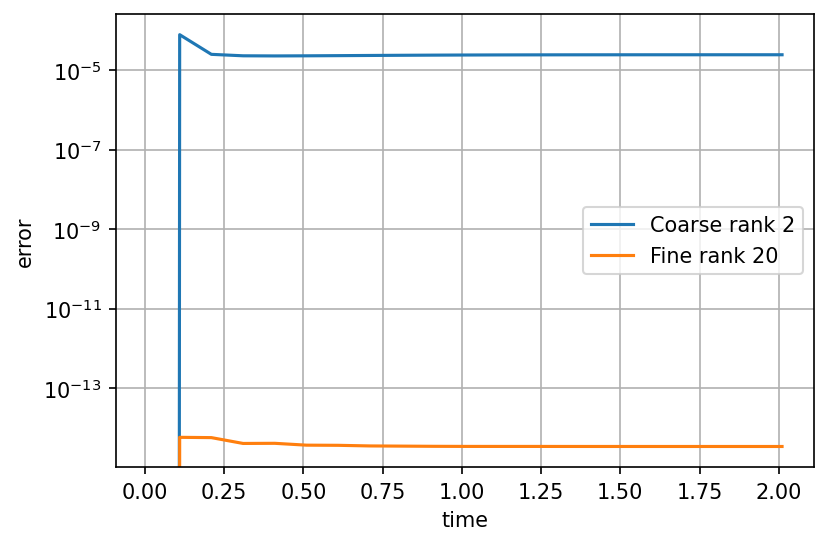

In [9]:
coarse_err = coarse_sol.compute_errors(ref_sol)
fine_err = fine_sol.compute_errors(ref_sol)
fig = plt.figure(2, dpi=150)
plt.semilogy(ts, coarse_err, label=f'Coarse rank {coarse_rank}')
plt.semilogy(ts, fine_err, label=f'Fine rank {fine_rank}')
plt.grid()
plt.legend()
plt.xlabel('time')
plt.ylabel('error')
plt.show()

### ANIMATION

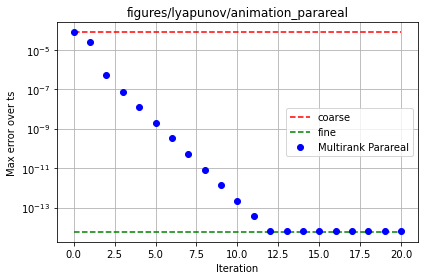

In [10]:
anim, err_coarse, err_fine, err_para = plotting.parareal_animation(ts, Unk, coarse_sol.Ys, fine_sol.Ys,
                                                                   ref_sol.Ys, title='figures/lyapunov/animation_parareal',
                                                                   coarse_name='coarse', fine_name='fine', do_save=True)
HTML(anim.to_jshtml())

## SEVERAL RANKS

### SEVERAL COARSE RANKS

Fine solver: 100%|██████████| 20/20 [00:06<00:00,  3.04it/s]


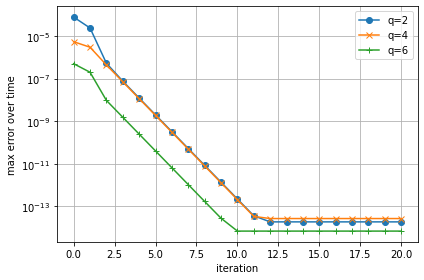

In [12]:
all_coarse_ranks = (2, 4, 6)
linestyles = ('-o', '-x', '-+')
it = np.arange(0, nb_t_steps+1)
fig = plt.figure(clear=True)
for k in range(len(all_coarse_ranks)):
    print(f'Coarse rank q={all_coarse_ranks[k]}')
    # PARAREAL
    ts, Unk, _, _ = parareal.Low_Rank_Parareal(PB, t_span, PB.Y0, nb_t_steps, coarse_rank=all_coarse_ranks[k], fine_rank=20, DLRA_method='KSL2', nb_substeps=20)
    # ERROR
    Enk = parareal.compute_parareal_error(ref_sol, Unk)
    # PLOT
    err_para = np.max(Enk, axis=0)
    plt.semilogy(it, err_para, linestyles[k], label=f'q={all_coarse_ranks[k]}')

plt.grid()
plt.xlabel('iteration')
plt.ylabel('max error over time')
plt.tight_layout()
plt.legend()
plt.show()
fig.savefig(f'figures/lyapunov/several_coarse_ranks.pdf')

### SEVERAL FINE RANKS

Fine rank q=12


Fine solver: 100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


Fine rank q=16


Fine solver: 100%|██████████| 20/20 [00:05<00:00,  3.59it/s]


Fine rank q=20


Fine solver: 100%|██████████| 20/20 [00:06<00:00,  3.32it/s]


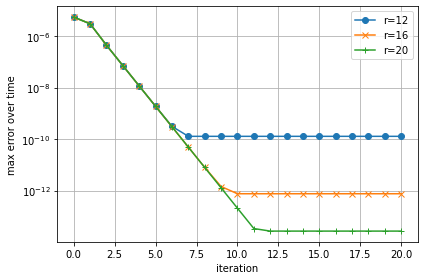

In [13]:
all_fine_ranks = (12, 16, 20)
linestyles = ('-o', '-x', '-+')
it = np.arange(0, nb_t_steps+1)
fig = plt.figure(clear=True)
for k in range(len(all_fine_ranks)):
    print(f'Fine rank q={all_fine_ranks[k]}')
    # PARAREAL
    ts, Unk, _, _ = parareal.Low_Rank_Parareal(PB, t_span, PB.Y0, nb_t_steps, coarse_rank=4, fine_rank=all_fine_ranks[k], DLRA_method='KSL2', nb_substeps=10)
    # ERROR
    Enk = parareal.compute_parareal_error(ref_sol, Unk)
    # PLOT
    err_para = np.max(Enk, axis=0)
    plt.semilogy(it, err_para, linestyles[k], label=f'r={all_fine_ranks[k]}')

plt.grid()
plt.xlabel('iteration')
plt.ylabel('max error over time')
plt.tight_layout()
plt.legend()
plt.show()
fig.savefig(f'figures/lyapunov/several_fine_ranks.pdf')

## SEVERAL SIZES

Size: 50


Fine solver: 100%|██████████| 50/50 [00:17<00:00,  2.79it/s]


Size: 100


Fine solver: 100%|██████████| 50/50 [01:23<00:00,  1.66s/it]


Size: 200


Fine solver: 100%|██████████| 50/50 [05:41<00:00,  6.82s/it]


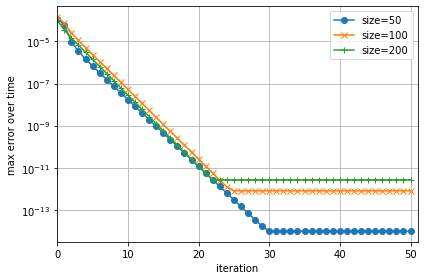

In [16]:
all_size = (50, 100, 200)
t_span = (0.01, 2.01)
nb_t_steps = 50
it = np.arange(0, nb_t_steps+1)
fig = plt.figure(clear=True)
linestyles = ('o-','x-','+-')
for k in range(len(all_size)):
    # MAKE PROBLEM
    print(f'Size: {all_size[k]}')
    PB = problem_set.make_stiff_problem(t_span, all_size[k])

    # COMPUTE EXACT SOLUTION
    full_iv = PB.Y0.full()
    ref_sol = classical_solvers.solve(PB, t_span, full_iv, nb_t_steps=nb_t_steps, monitoring=True)

    # COMPUTE LOW-RANK PARAREAL
    n_sub = int(20*all_size[k]**2/50**2)
    ts, Unk, _, _ = parareal.Low_Rank_Parareal(PB, t_span, PB.Y0, nb_t_steps, coarse_rank=2, fine_rank=20, DLRA_method='KSL2', nb_substeps=n_sub)
    Enk = parareal.compute_parareal_error(ref_sol, Unk)
    max_Enk = np.max(Enk, axis=0)

    # PLOT
    plt.semilogy(it, max_Enk, linestyles[k], label=f'size={all_size[k]}')

plt.grid()
plt.xlabel('iteration')
plt.ylabel('max error over time')
plt.tight_layout()
plt.xlim((0,nb_t_steps+1))
plt.legend()
plt.show()
fig.savefig('figures/lyapunov/several_size.pdf')

## SEVERAL FINAL TIME

Time: (0.01, 1.01)


Fine solver: 100%|██████████| 50/50 [00:17<00:00,  2.81it/s]


Time: (0.01, 2.01)


Fine solver: 100%|██████████| 50/50 [00:33<00:00,  1.47it/s]


Time: (0.01, 4.01)


Fine solver: 100%|██████████| 50/50 [01:11<00:00,  1.43s/it]


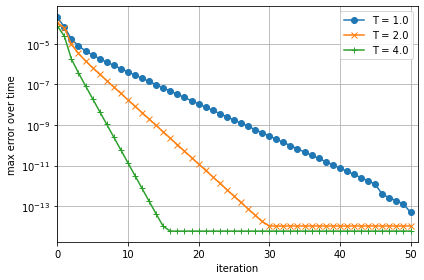

In [20]:
size = 50
all_t_span = ((0.01, 1.01), (0.01, 2.01), (0.01, 4.01))
nb_t_steps = 50
it = np.arange(0, nb_t_steps+1)
fig = plt.figure(clear=True)
linestyles = ('o-','x-','+-')
for k in range(len(all_t_span)):
    # MAKE PROBLEM
    print(f'Time: {all_t_span[k]}')
    PB = problem_set.make_stiff_problem(all_t_span[k], size)

    # COMPUTE EXACT SOLUTION
    full_iv = PB.Y0.full()
    ref_sol = classical_solvers.solve(PB, all_t_span[k], full_iv, nb_t_steps=nb_t_steps, monitoring=True)

    # COMPUTE LOW-RANK PARAREAL
    n_sub = int(20 * 2 ** k)
    ts, Unk, _, _ = parareal.Low_Rank_Parareal(PB, all_t_span[k], PB.Y0, nb_t_steps, coarse_rank=2, fine_rank=20, DLRA_method='KSL2', nb_substeps=n_sub)
    Enk = parareal.compute_parareal_error(ref_sol, Unk)
    max_Enk = np.max(Enk, axis=0)

    # PLOT
    plt.semilogy(it, max_Enk, linestyles[k], label=f'T = {round(all_t_span[k][1]-all_t_span[k][0], 2)}')

plt.grid()
plt.xlabel('iteration')
plt.ylabel('max error over time')
plt.tight_layout()
plt.xlim((0,nb_t_steps+1))
plt.legend()
plt.show()
fig.savefig('figures/lyapunov/several_time.pdf')